### MaxFuse running on 10x mouse e18

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc

import sys
sys.path.append("../../MaxFuse_devo/09302022V/")
import match
import metrics
from scipy.io import mmread
import os

In [2]:
meta_rna = pd.read_csv('atac_bench_nrz/10x_e18/data/10x_e18_meta.csv')
celltype_labels_rna = meta_rna['celltype'].to_numpy()
np.unique(celltype_labels_rna)

array(['Cajal-Retzius', 'Cortical or hippocampal glutamatergic',
       'Forebrain GABAergic', 'Glioblast', 'Neuroblast',
       'Oligodendrocyte', 'Radial glia'], dtype=object)

In [3]:
# read in the counts
rna = mmread("atac_bench_nrz/10x_e18/data/10x_e18_rna.txt").tocsr()
rna.shape

(3981, 13973)

In [4]:
# read in the names
rna_names = pd.read_csv(
    'atac_bench_nrz/10x_e18/data/10x_e18_rna_names.csv'
)['names'].to_numpy()

In [5]:
atacactivity=mmread("atac_bench_nrz/10x_e18/data/10x_e18_GAS.txt").tocsr()
atacactivity.shape

(3981, 21977)

In [6]:
# activity names
gas_names = pd.read_csv(
    'atac_bench_nrz/10x_e18/data/10x_e18_GAS_names.csv'
)['names'].to_numpy()

In [7]:
peak_lsi = pd.read_csv('atac_bench_nrz/10x_e18/data/10x_e18_LSI49.csv')
peak_lsi = peak_lsi.drop('Unnamed: 0', axis=1)
peak_lsi.shape

(3981, 49)

In [8]:
## make rna anndata
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names
rna_adata.obs_names = meta_rna['Unnamed: 0']
rna_adata

AnnData object with n_obs × n_vars = 3981 × 13973

In [9]:
## make GAS anndata
activity_adata = ad.AnnData(atacactivity, dtype=np.float32)
activity_adata.var_names = gas_names
activity_adata

AnnData object with n_obs × n_vars = 3981 × 21977

In [10]:
peak_adata=ad.AnnData(peak_lsi, dtype=np.float32)
peak_adata

/home/bkzhu/python/miniconda3/envs/super_mario_testing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3981 × 49

In [11]:
shared_genes = np.intersect1d(rna_adata.var_names, activity_adata.var_names)
len(np.intersect1d(rna_adata.var_names, activity_adata.var_names))

13973

In [12]:
rna_shared = rna_adata[:, shared_genes].X.todense()
activity_shared = activity_adata[:, shared_genes].X.todense()

mask = ((rna_shared.std(axis=0) > 0.01) & (activity_shared.std(axis=0) > 0.01)).A1 # filter out static ones
rna_shared = rna_shared[:, mask]
activity_shared = activity_shared[:, mask]

In [13]:
# no need to norm since sct normed but can find var featgures and scale
rna_shared = ad.AnnData(rna_shared)
#sc.pp.normalize_total(rna_shared)
#sc.pp.log1p(rna_shared)
sc.pp.highly_variable_genes(rna_shared, n_top_genes = 3000)
sc.pp.scale(rna_shared)
#rna_shared = rna_shared.X

# same for all counts
sc.pp.scale(rna_adata)

## atac shared
activity_shared = ad.AnnData(activity_shared)
sc.pp.normalize_total(activity_shared)
sc.pp.log1p(activity_shared)
sc.pp.scale(activity_shared)
#activity_shared = activity_shared.X

In [14]:
vgenes = rna_shared.var.highly_variable

In [15]:
# shared features
rnaC_shared = rna_shared[:,vgenes].X
atac_shared = activity_shared[:,vgenes].X
# all features
rnaC_active = rna_adata.X
atac_active = peak_adata.X

## MF start

In [16]:
spm = match.MaxFuse(
    shared_arr1=np.array(rnaC_shared),
    shared_arr2=np.array(atac_shared),
    active_arr1=np.array(rnaC_active),
    active_arr2=np.array(atac_active),
    method='centroid_shrinkage',
    labels1=None, # if None, then use scanpy clustering pipeline
    labels2=None
)

In [17]:
spm.split_into_batches(
        max_outward_size=5000,
        matching_ratio=5,
        metacell_size=2,
        method='binning',
        verbose=True,
        seed=42
    )

The first data is split into 2 batches, average batch size is 1990, and max batch size is 1991.
The second data is split into 1 batches, average batch size is 3981, and max batch size is 3981.
Batch to batch correspondence is:
  ['0<->0', '1<->0'].


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0ca096bd30>)

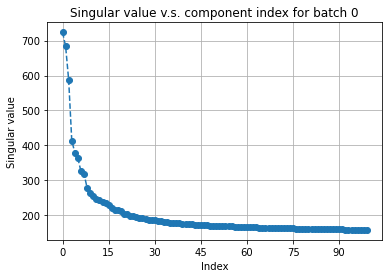

In [18]:
spm.plot_singular_values(
    target='active_arr1',
    batch=0,
    n_components=None,
    randomized_svd=False,  # @Shuxiao: Had to change this from True to False.  Doesn't work when true, why?
    svd_runs=1
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0ca0e20220>)

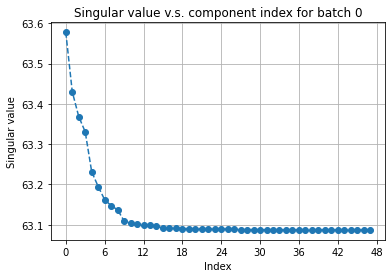

In [19]:
spm.plot_singular_values(
    target='active_arr2',
    batch=None,
    n_components=None,
    randomized_svd=False, # @Shuxiao: Had to change this from True to False.  Doesn't work when true, why?
    svd_runs=1
)

In [52]:
spm.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=35,
    svd_components2=18,
    resolution1=2,
    resolution2=2,
    randomized_svd=False,  # @Shuxiao: Had to change this from True to False.  Doesn't work when true, why?
    svd_runs=1,
    resolution_tol=0.1,
    leiden_runs=1,
    leiden_seed=None,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Now at batch 1...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0c7d009b20>)

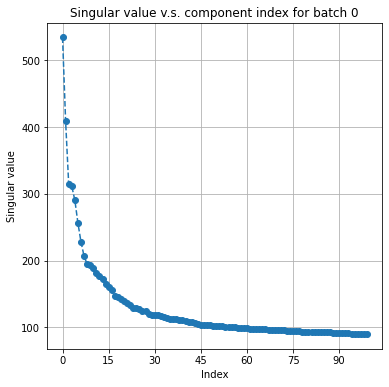

In [53]:
spm.plot_singular_values(
    target='shared_arr1',
    batch=None,
    n_components=None,
    randomized_svd=False,
    svd_runs=1
)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0c7d669190>)

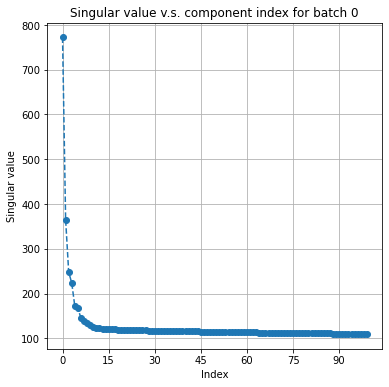

In [54]:
spm.plot_singular_values(
    target='shared_arr2',
    batch=None,
    n_components=None,
    randomized_svd=False,
    svd_runs=1
)

In [55]:
spm.find_initial_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=35, svd_components2=18,
    randomized_svd=False, svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Done!


In [56]:
# test accuracy of initial matching
import utils, metrics
matching = spm._init_matching[0]
labels1 = utils.summarize_clustering(spm._metacell_labels1[0], celltype_labels_rna[spm._batch_to_indices1[0]])
# labels1 = celltype_labels_rna[spm._batch_to_indices1[0]]
labels2 = celltype_labels_rna[spm._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.893467336683417

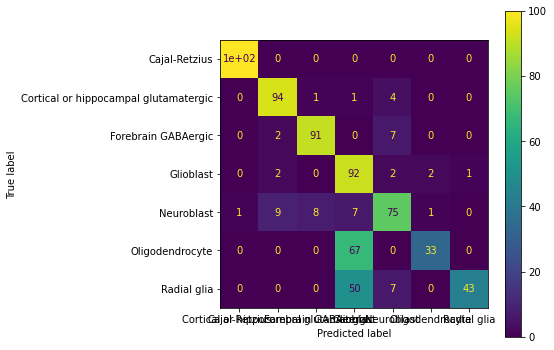

In [57]:
plt.rcParams["figure.figsize"] = (6,6)
cm = confusion_matrix(np.array(labels1)[matching[0]],
                      np.array(labels2)[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
#     confusion_matrix=cm,
    display_labels=np.unique(labels1)
).plot()

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0c7c52e520>)

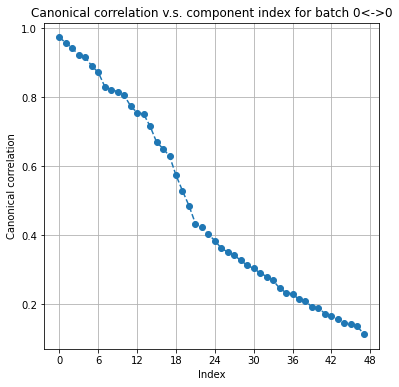

In [58]:
spm.plot_canonical_correlations(
    batch=0,
    svd_components1=100, 
    svd_components2=None,
    cca_components=48,
    filter_prop=0.,
    randomized_svd=False,
    svd_runs=1,
    cca_max_iter=2000
)
# need to specify svd_components here explicitly as n_sample < n_feature!

In [90]:
spm.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=100, svd_components2=None,
    cca_components=20,
    filter_prop=0.,
    n_iters=8,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Done!


In [91]:
# test accuracy of refined matching
matching = spm._refined_matching[0]
labels1 = utils.summarize_clustering(spm._metacell_labels1[0], celltype_labels_rna[spm._batch_to_indices1[0]])
# labels1 = celltype_labels_rna[spm._batch_to_indices1[0]]
labels2 = celltype_labels_rna[spm._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.9195979899497487

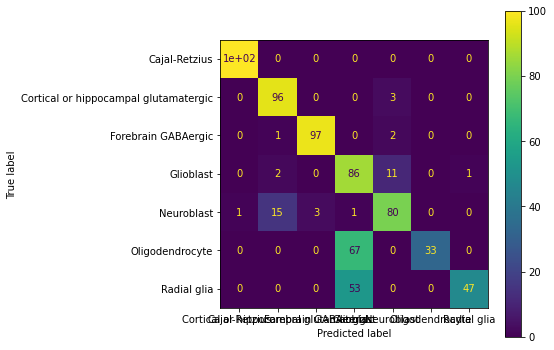

In [92]:
# plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(np.array(labels1)[matching[0]],
                      np.array(labels2)[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
#     confusion_matrix=cm,
    display_labels=np.unique(labels1)
).plot()

In [93]:
spm.filter_bad_matches(target='pivot', filter_prop=0.4, verbose=True)

Begin filtering...
Now at batch 0<->0...
Now at batch 1<->0...
1194/1990 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
2376/3981 cells in arr1 are selected as pivots.
1014/3981 cells in arr2 are selected as pivots.
Done!


In [94]:
matching = spm.get_matching(order=(1, 2), target='pivot')
metrics.get_matching_acc(matching, celltype_labels_rna, celltype_labels_rna)

0.9292929292929293

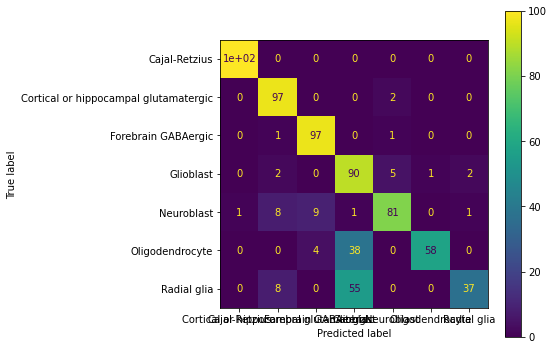

In [95]:
# plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(celltype_labels_rna[matching[0]],
                      celltype_labels_rna[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
#     confusion_matrix=cm,
    display_labels=np.unique(celltype_labels_rna)
).plot()

In [96]:
spm.propagate(
    wt1=0.7,
    wt2=0.7,
    svd_components1=30, 
    svd_components2=None, 
    randomized_svd=False, 
    svd_runs=1, 
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Done!


In [97]:
spm.filter_bad_matches(
    target='propagated',
    filter_prop=0.,
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
Now at batch 1<->0...
7564/7564 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [98]:
matching = spm.get_matching(order=(2, 1), target='full_data')
metrics.get_matching_acc(matching, celltype_labels_rna, celltype_labels_rna, order = (2, 1))

0.9095704596834966

In [99]:
#matching = spm.get_matching(order=(1, 2), target='full_data')
#metrics.get_matching_acc(matching, celltype_labels_rna, celltype_labels_rna)

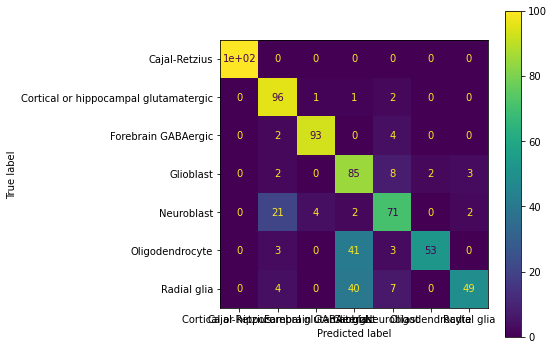

In [100]:
# plt.rcParams["figure.figsize"] = (10,6)
cm = confusion_matrix(celltype_labels_rna[matching[0]],
                      celltype_labels_rna[matching[1]])
ConfusionMatrixDisplay(
    confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100),
#     confusion_matrix=cm,
    display_labels=np.unique(celltype_labels_rna)
).plot()

In [101]:
full = pd.DataFrame(list(zip(matching[0],matching[1],matching[2])), columns = ["idx1","idx2","score"])
full.to_csv("atac_bench_nrz/10x_e18/mf/full_idx_21.csv", index=False)

In [102]:
arr1_cca, arr2_cca = spm.get_embedding(
        active_arr1 = spm.active_arr1,
        active_arr2 = spm.active_arr2,
        refit=False,
        matching=None,
        order=None,
        cca_components=20,
        cca_max_iter=None
    )

In [103]:
out_idx = 20 # save out 20 but used 15 in final analysis
arr1_df = pd.DataFrame(arr1_cca).iloc[:,0:out_idx]
arr2_df = pd.DataFrame(arr2_cca).iloc[:,0:out_idx]
arr1_df.to_csv("atac_bench_nrz/10x_e18/mf/full_embed_x0.csv",index=False)
arr2_df.to_csv("atac_bench_nrz/10x_e18/mf/full_embed_y0.csv", index=False)